# 1.2. MD Forecasting with Machine Learning Models

Machine learning models, particularly boosting models, dominated the leaderboard in this competition. I plan to build and compare several ML models to assess their performance.

In [1]:
import os, datetime
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

from utils import SMAPE
import xgboost as xgb

pd.options.mode.chained_assignment = None 
random_state = 42

In [2]:
data_dir = '../data/'

# train data
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_revealed_test = pd.read_csv(os.path.join(data_dir, 'revealed_test.csv'))
df_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
df_census = pd.read_csv(os.path.join(data_dir, 'census_starter.csv'))

# test data
df_test = pd.read_csv(os.path.join(data_dir, 'all_revealed_test.csv'))

## 1. Data Prep

- inputs: cfips_ord(index), state_ord, year, month, n_months
- outputs: microbusiness_density

In [3]:
# convert str to datetime
df_train.first_day_of_month = pd.to_datetime(df_train.first_day_of_month)

In [4]:
# decompose row_id of test dataset
df_test['cfips'] = df_test.row_id.apply(lambda x: int(x.split('_')[0]))
df_test['first_day_of_month'] = pd.to_datetime(df_test.row_id.apply(lambda x: x.split('_')[1]))

# create state column in test dataset
cfips2state = {cfips: state for cfips, state in df_train[['cfips', 'state']].drop_duplicates().values}
df_test['state'] = df_test.cfips.map(cfips2state)

df_test.head()

,row_id,microbusiness_density,cfips,first_day_of_month,state
0,1001_2022-11-01,3.442677,1001,2022-11-01,Alabama
1,1003_2022-11-01,8.257636,1003,2022-11-01,Alabama
2,1005_2022-11-01,1.247223,1005,2022-11-01,Alabama
3,1007_2022-11-01,1.275998,1007,2022-11-01,Alabama
4,1009_2022-11-01,1.836289,1009,2022-11-01,Alabama


In [5]:
# label encoding of cfips and state
cfips2id = {cfips: idx for idx, cfips in enumerate(df_train.cfips.unique())}
id2cfips = {idx: cfips for cfips, idx in cfips2id.items()}

state2id = {state: idx for idx, state in enumerate(df_train.state.unique())}
id2state = {idx: state for state, idx in state2id.items()}

# train dataset
df_train['cfips_ord'] = df_train.cfips.map(cfips2id)
df_train['state_ord'] = df_train.state.map(state2id)

# test dataset
df_test['cfips_ord'] = df_test.cfips.map(cfips2id)
df_test['state_ord'] = df_test.state.map(state2id)

In [6]:
# first_day_of_month into numeric columns -> month, year, n_months

df_train['month'] = df_train.first_day_of_month.dt.month
df_train['year'] = df_train.first_day_of_month.dt.year

df_test['month'] = df_test.first_day_of_month.dt.month
df_test['year'] = df_test.first_day_of_month.dt.year


def month_difference(val1, val2):
	difference = relativedelta(val1, val2)
	return difference.years * 12 + difference.months

latest_month = df_test.first_day_of_month.max()

df_train['n_months'] = df_train.first_day_of_month.apply(
	lambda x: month_difference(latest_month, x))

df_test['n_months'] = df_test.first_day_of_month.apply(
	lambda x: month_difference(latest_month, x))

### 1.2. train valid split

In [7]:
input_features = ['cfips_ord', 'state_ord', 'month', 'year', 'n_months']

X_train = df_train[input_features]
X_test = df_test[input_features]

y_train = df_train['microbusiness_density']
y_test = df_test['microbusiness_density']

In [8]:
# split train and val along time with ratio 0.2
X_val = X_train[(X_train['year'] >= 2022) & (X_train['month'] >= 3)]
X_train = X_train[~X_train.index.isin(X_val.index)]

y_val = y_train[X_val.index]
y_train = y_train[X_train.index]

In [9]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((97185, 5), (25080, 5), (25080, 5), (97185,), (25080,), (25080,))

## 2. Non-Boosting Models

SVR, Random Forest, KNN

In [10]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [11]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, verbose=True)
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
knn_model = KNeighborsRegressor(n_neighbors=3)

for modelname, model in zip(['SVR', 'RF', 'KNN'], [svr_model, rf_model, knn_model]):
	model.fit(X_train, y_train)
	preds = model.predict(X_val)
	print(f"{modelname} SMAPE:", SMAPE(y_val, preds))

[LibSVM].............................................................
*.
*..
*
optimization finished, #iter = 63570
obj = -201039.563967, rho = -1.971913
nSV = 92930, nBSV = 92923
SVR SMAPE: 54.59590867385068
RF SMAPE: 4.120553349462838
KNN SMAPE: 41.924357223147034


총 9분 소요

- SVR SMAPE: 54.59590867385068
- RF SMAPE: 4.120553349462838
- KNN SMAPE: 41.924357223147034

With default hyper parameters, Random Forest works well. Let's use this model.

## 3. Boosting model

GBM, XGB, LightGBM, CatBoost

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

In [14]:
gbm_params = {
	'learning_rate': 0.2, 
	'min_samples_split': 500,
	'min_samples_leaf': 50,
	'max_depth': 6,
	'max_features': 'sqrt',
	'subsample': 0.8,
	'random_state': random_state,
	'loss': 'huber',
}

lgbm_params = {
	'objectives': 'huber',
	'metric': 'mae',
	'learning_rate': 0.05,
	'num_leaves':31,
	'max_depth': 8,
	'min_data_in_leaf': 20,
	'lambda_l1': 0.1,
	'lambda_l2': 0.1,
	'feature_fraction': 0.6,
	'bagging_fraction': 0.7,
	'bagging_freq': 5,
	'boosting_type': 'gbdt',
	'n_estimators': 1000,
}

In [15]:
gbm_model = GradientBoostingRegressor(verbose=False, **gbm_params)
gbm_model = gbm_model.fit(X_train, y_train)
preds = gbm_model.predict(X_val)
print(f"GBM SMAPE:", SMAPE(y_val, preds))

lgbm_model = lgb.LGBMRegressor(verbose=-1, **lgbm_params)
lgbm_model = lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
preds = lgbm_model.predict(X_val)
print(f"LGB SMAPE:", SMAPE(y_val, preds))

xgb_model = xgb.XGBRegressor()
xgb_model = xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
preds = xgb_model.predict(X_val)
print(f"XGB SMAPE:", SMAPE(y_val, preds))

catboost_model = CatBoostRegressor(verbose=0)
catboost_model = catboost_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
preds = catboost_model.predict(X_val)
print(f"Catboost SMAPE:", SMAPE(y_val, preds))

GBM SMAPE: 46.56014817609906
LGB SMAPE: 50.43115076555283
XGB SMAPE: 49.69345990216143
Catboost SMAPE: 50.1569603446478


Basic Parameter Results
- SVR SMAPE: 54.59590867385068
- RF SMAPE: 4.120553349462838
- KNN SMAPE: 41.924357223147034
- GBM SMAPE: 46.56014817609906
- LGB SMAPE: 50.43115076555283
- XGB SMAPE: 49.69345990216143
- Catboost SMAPE: 50.1569603446478

## 4. Random Forest targetting `active`

Since the evaluation metric is SMAPE, which is percentage-based, we can evaluate `active` predictions directly without converting them into density.”

In [23]:
# load census
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df_submission = df_test.copy()

for year in range(2017, 2022):
	df_census = pd.read_csv(
		os.path.join(data_dir, 'census', f'ACSST5Y{year}.S0101-Data.csv'),
		usecols=COLS, 
		low_memory=False
		).iloc[1:]
	df_census['S0101_C01_026E'] = df_census['S0101_C01_026E'].astype('int')

	df_census['cfips'] = df_census.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
	population = df_census.set_index('cfips').S0101_C01_026E.to_dict()

	df_train[f'adult{year}'] = df_train.cfips.map(population)
	df_submission[f'adult{year}'] = df_submission.cfips.map(population)

In [24]:
#  based on adult population
for i, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
	year = row['year']-2
	adultpop = row[f'adult{year}']

	df_train.loc[i, 'adultpop'] = adultpop

df_train.head()

100%|██████████| 122265/122265 [00:13<00:00, 8775.61it/s]


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,cfips_ord,state_ord,month,year,n_months,adult2017,adult2018,adult2019,adult2020,adult2021,adultpop
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,0,0,8,2019,46,41527,41831,42175,42496,44438,41527.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,0,0,9,2019,45,41527,41831,42175,42496,44438,41527.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,0,0,10,2019,44,41527,41831,42175,42496,44438,41527.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,0,0,11,2019,43,41527,41831,42175,42496,44438,41527.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,0,0,12,2019,42,41527,41831,42175,42496,44438,41527.0


In [25]:
# estimate active based on adult population
for i, row in tqdm(df_submission.iterrows(), total=df_submission.shape[0]):
	year = row['year']-2
	adultpop = row[f'adult{year}']
	active = row['microbusiness_density'] * adultpop / 100

	df_submission.loc[i, 'active'] = active
	df_submission.loc[i, 'adultpop'] = adultpop

100%|██████████| 25080/25080 [00:04<00:00, 5073.08it/s]


In [26]:
submission = df_submission[~df_submission.microbusiness_density.isna()]

target_var = 'microbusiness_density' # active, microbusiness_density

X_train = df_train[input_features]# + ['adultpop']]
X_test = submission[input_features]# + ['adultpop']]

y_train = df_train[target_var]
y_test = submission[target_var]

In [27]:
# random forest targetting active instead of md
rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print(f"Random Forest {target_var} SMAPE:", SMAPE(submission[target_var], preds))

Random Forest microbusiness_density SMAPE: 5.293179103001052


In [28]:
# Adjusted Results

if target_var == 'microbusiness_density':
	adjusted_preds = preds * submission['adult2020'] / submission['adultpop']
	print(f"Random Forest adjusted {target_var} SMAPE:", SMAPE(submission[target_var], adjusted_preds))
elif target_var == 'active':
	adjusted_preds = preds / submission['adultpop'] * 100
	print(f"Random Forest adjusted {target_var} SMAPE:", SMAPE(submission['microbusiness_density'], adjusted_preds))

Random Forest adjusted microbusiness_density SMAPE: 4.699056726960653


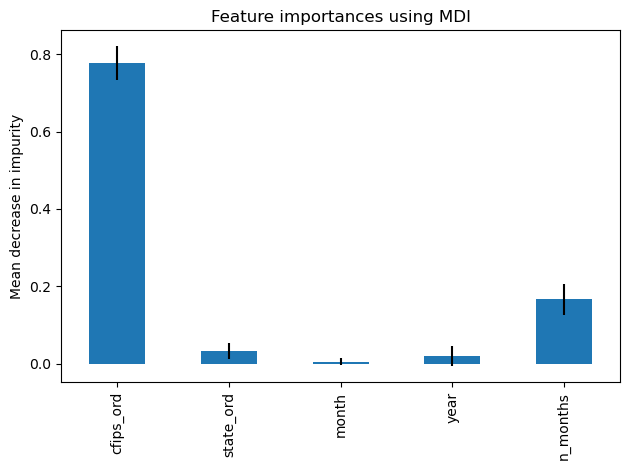

In [29]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(rf_model.feature_importances_, index=rf_model.feature_names_in_)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Comparison Results:

- [ACTIVE] w/o adultpop: 4.6568
- [ACTIVE] w/  adultpop: 14.8872
- [MD]     w/o adultpop: 5.2891 # 4.6990 (after adjusting)
- [MD]     w/  adultpop: 11.5327

Conclusion:

- The feature `adultpop` appears to be highly correlated with the target column, `active`, leading to overfitting when included in the model.
- While both targets are comparable, modeling `active` seems slightly easier than directly targeting `microbusiness_density`.
- The most SURPRISING thing is that ML models with basic parameters hardly outperform the last value forecasting.
- Random Forest Feature Importance: `CFIPS` > `n_months` > `state` > `year` > `month`